In [1]:
import pandas as pd

df = pd.read_csv('labeled3.csv')

total_counts = df['label'].value_counts()
print(total_counts)

yearly_counts = df.groupby(['year', 'label']).size().unstack(fill_value=0)
print("\nCounts for each year:")
print(yearly_counts)


label
LIVE    153
DEAD    113
BARE    103
Name: count, dtype: int64

Counts for each year:
label  BARE  DEAD  LIVE
year                   
2014     19    23    28
2016     16    18    39
2018     31    22    24
2020     11    24    38
2022     26    26    24


/Users/devparagiri/Research/tree-mortality-v3/env/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


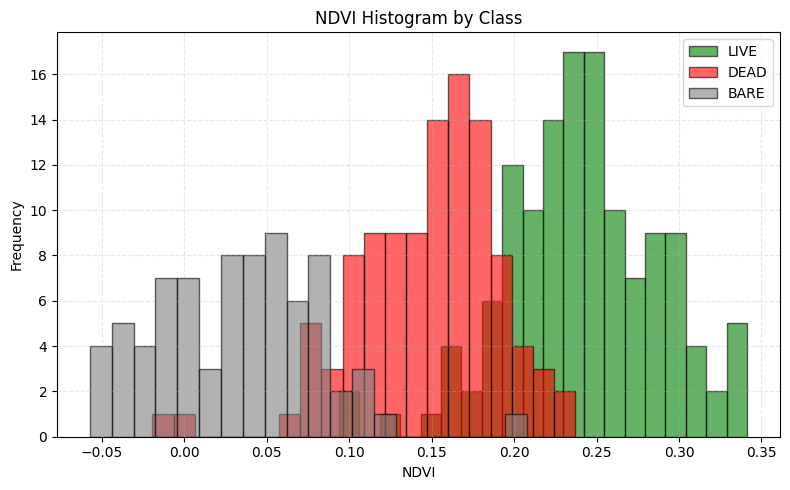

In [2]:
import os
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === CONFIG ===
LABEL_FILE = "labeled2.csv"
IMAGE_DIR = "labeled_samples"
CLASSES = ["LIVE", "DEAD", "BARE"]
colors = {"LIVE": "green", "DEAD": "red", "BARE": "gray"}

# === Collect NDVI values by class ===
ndvi_by_class = {cls: [] for cls in CLASSES}
df = pd.read_csv(LABEL_FILE)

for _, row in df.iterrows():
    label = row["label"]
    if label not in CLASSES:
        continue

    tif_path = os.path.join(IMAGE_DIR, row["filename"].replace(".png", ".tif"))
    if not os.path.exists(tif_path):
        continue

    with rasterio.open(tif_path) as src:
        data = src.read()
        red, nir = float(data[0, 0, 0]), float(data[3, 0, 0])
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_by_class[label].append(ndvi)

# === Plot ===
plt.figure(figsize=(8, 5))
for label in CLASSES:
    plt.hist(ndvi_by_class[label], bins=20, alpha=0.6, label=label, color=colors[label], edgecolor='black')

plt.title("NDVI Histogram by Class")
plt.xlabel("NDVI")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/Users/devparagiri/Research/tree-mortality-v3/env/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/var/folders/5g/yd1vdsh57t939808t_l412f00000gn/T/ipykernel_62570/1046160654.py:22: RuntimeWarning: overflow encountered in scalar subtract
  ndvi = (nir - r) / (nir + r + 1e-6)


<Figure size 450x450 with 0 Axes>

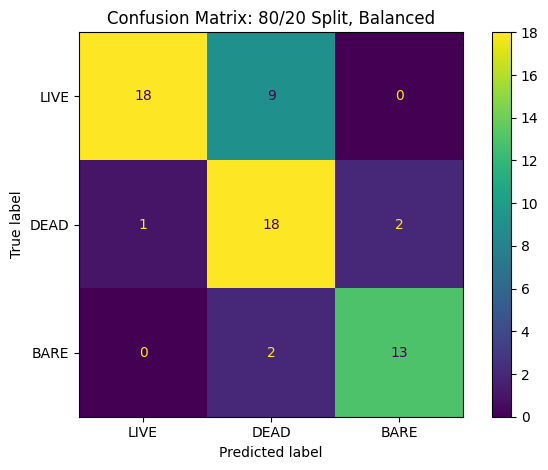

In [3]:
import pandas as pd
import numpy as np
import os
import rasterio
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# === CONFIG ===
LABEL_FILE = "labeled2.csv"
IMAGE_DIR = "labeled_samples"
CLASSES = ["LIVE", "DEAD", "BARE"]
LABEL_TO_INT = {label: i for i, label in enumerate(CLASSES)}
INT_TO_LABEL = {i: label for label, i in LABEL_TO_INT.items()}

# === Feature Extractor ===
def extract_features(path):
    with rasterio.open(path) as src:
        bands = src.read()
        r, g, b, nir = bands[0, 0, 0], bands[1, 0, 0], bands[2, 0, 0], bands[3, 0, 0]
        ndvi = (nir - r) / (nir + r + 1e-6)
        return [r, g, b, nir, ndvi]

# === Load labeled data ===
df = pd.read_csv(LABEL_FILE)
df = df[df["label"].isin(CLASSES)]

X, y = [], []
for _, row in df.iterrows():
    tif_path = os.path.join(IMAGE_DIR, row["filename"].replace(".png", ".tif"))
    if os.path.exists(tif_path):
        X.append(extract_features(tif_path))
        y.append(LABEL_TO_INT[row["label"]])

# === Train/test split and model ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# === Plot confusion matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(4.5, 4.5))
disp.plot(cmap="viridis", values_format='d')
plt.title("Confusion Matrix: 80/20 Split, Balanced")
plt.tight_layout()
plt.show()

In [10]:
import rasterio
import numpy as np
from collections import Counter
import glob
import os

# === CONFIG ===
TIF_GLOB = "predicted_rasters/predicted_class_map_*.tif"
CLASS_NAMES = {0: "LIVE", 1: "DEAD", 2: "BARE", 255: "NODATA"}

# === Find all TIFs ===
tif_files = sorted(glob.glob(TIF_GLOB))

for TIF_PATH in tif_files:
    # === Load raster ===
    with rasterio.open(TIF_PATH) as src:
        pred = src.read(1)
        nodata = src.nodata if src.nodata is not None else 255

    # === Count pixel values
    flat = pred.flatten()
    counts = Counter(flat)

    # === Total non-nodata pixels
    valid_total = sum(v for k, v in counts.items() if k != nodata)
    total = flat.size

    # === Print breakdown
    print(f"📊 Pixel Distribution for: {os.path.basename(TIF_PATH)}\n")
    for cls_id in sorted(counts):
        count = counts[cls_id]
        label = CLASS_NAMES.get(cls_id, f"Class {cls_id}")
        pct = (count / total) * 100
        print(f"{label:>7}: {count:,} pixels ({pct:.2f}%)")

    print(f"\n✅ Total labeled pixels (excluding nodata): {valid_total:,}\n{'-'*40}\n")

📊 Pixel Distribution for: predicted_class_map_2014.tif

   LIVE: 14,035 pixels (8.73%)
   DEAD: 41,409 pixels (25.75%)
   BARE: 70,185 pixels (43.65%)
 NODATA: 35,172 pixels (21.87%)

✅ Total labeled pixels (excluding nodata): 125,629
----------------------------------------

📊 Pixel Distribution for: predicted_class_map_2016.tif

   LIVE: 17,560 pixels (10.92%)
   DEAD: 38,873 pixels (24.17%)
   BARE: 69,196 pixels (43.03%)
 NODATA: 35,172 pixels (21.87%)

✅ Total labeled pixels (excluding nodata): 125,629
----------------------------------------

📊 Pixel Distribution for: predicted_class_map_2018.tif

   LIVE: 18,983 pixels (11.81%)
   DEAD: 34,204 pixels (21.27%)
   BARE: 72,936 pixels (45.36%)
 NODATA: 34,678 pixels (21.57%)

✅ Total labeled pixels (excluding nodata): 126,123
----------------------------------------

📊 Pixel Distribution for: predicted_class_map_2020.tif

   LIVE: 21,241 pixels (13.21%)
   DEAD: 31,112 pixels (19.35%)
   BARE: 73,770 pixels (45.88%)
 NODATA: 34,678